<a href="https://colab.research.google.com/github/marongkang/MLeveryday/blob/main/2022c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import urllib.request

In [ ]:
BCurl='https://github.com/marongkang/datasets/raw/main/BCHAIN-MKPRU.csv'
Gurl='https://github.com/marongkang/datasets/raw/main/LBMA-GOLD.csv'

BCrps=urllib.request.urlopen(BCurl)
Grps=urllib.request.urlopen(Gurl)

BChtml=BCrps.read()
Ghtml=Grps.read()

f1=open('BCHAIN-MKPRU.csv','wb')
f1.write(BChtml)
f2=open('LBMA-GOLD.csv','wb')
f2.write(Ghtml)

20625

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import numpy as np


In [ ]:
BCdf=pd.read_csv('BCHAIN-MKPRU.csv')
Gdf=pd.read_csv('LBMA-GOLD.csv')

In [ ]:
BCdf['Date']=pd.to_datetime(BCdf['Date'])
Gdf['Date']=pd.to_datetime(Gdf['Date'])
Gdf['Return']=0

#数据预处理
**缺失值分析**

**KNN**

In [ ]:
import sklearn
from sklearn.impute import KNNImputer

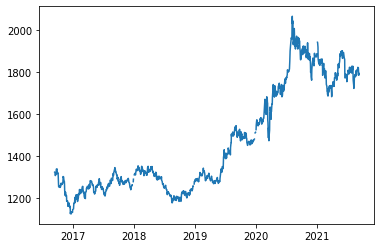

In [ ]:
plt.plot(Gdf['Date'],Gdf['USD (PM)'])

In [ ]:
#效果不佳
'''
imputer = KNNImputer(n_neighbors=30,
            weights='distance'         
            )
imputed = imputer.fit_transform(Gdf[['Return','USD (PM)']])
df_imputed = pd.DataFrame(imputed, columns=Gdf[['Return','USD (PM)']].columns)
Gdf[['Return','USD (PM)']]=df_imputed
'''

"\nimputer = KNNImputer(n_neighbors=30,\n            weights='distance'         \n            )\nimputed = imputer.fit_transform(Gdf[['Return','USD (PM)']])\ndf_imputed = pd.DataFrame(imputed, columns=Gdf[['Return','USD (PM)']].columns)\nGdf[['Return','USD (PM)']]=df_imputed\n"

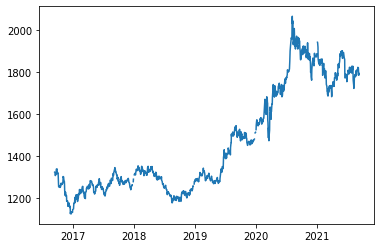

In [ ]:
plt.plot(Gdf['Date'],Gdf['USD (PM)'])

**dropna**

In [ ]:
Gdf=Gdf.dropna()
Gdf=Gdf.reset_index()

#计算关键指标

In [ ]:
BCret=[0]
for i in range(1,len(BCdf)):
  BCret.append((BCdf['Value'][i]-BCdf['Value'][i-1])/BCdf['Value'][i-1])
Gret=[0]
for i in range(1,len(Gdf)):
  Gret.append((Gdf['USD (PM)'][i]-Gdf['USD (PM)'][i-1])/Gdf['USD (PM)'][i-1])

In [ ]:
BCdf['Return']=BCret
Gdf['Return']=Gret

|index|Value|Return|Var|
|---|---|---|---|
|count|1826\.0|1826\.0|1826\.0|
|mean|12206\.068281468402|0\.0032333670412730536|0\.0016046231673695472|
|std|14043\.891626844317|0\.041475857776247516|0\.0004943415076093683|
|min|594\.08|-0\.39140443386063384|0\.0|
|25%|3994\.9825|-0\.012508367874880424|0\.0016626569540600347|
|50%|7924\.46|0\.001438775113487313|0\.001724851684370721|
|75%|11084\.73|0\.0190618988914242|0\.0018092466918252334|
|max|63554\.44|0\.21866893459705275|0\.002272227021372883|

In [ ]:
#计算收益等级
Glabel=[]
for i in range(len(Gdf)):
  if Gdf['Return'][i]>= 0.004494:
    Glabel.append(0)
  elif Gdf['Return'][i]>=0.000203:
    Glabel.append(1)
  elif Gdf['Return'][i]>=-0.004267:
    Glabel.append(2)
  else:
    Glabel.append(3)
Gdf['Label']=Glabel

In [ ]:
#计算收益等级
BClabel=[]
for i in range(len(BCdf)):
  if BCdf['Return'][i]>= 0.019062:
    BClabel.append(0)
  elif BCdf['Return'][i]>=0.001439:
    BClabel.append(1)
  elif BCdf['Return'][i]>=-0.012508:
    BClabel.append(2)
  else:
    BClabel.append(3)
BCdf['Label']=BClabel

**指数加权移动平均(Exponentially Weighted Average)**

In [ ]:
#args
beta=0.9

In [ ]:
def EW_avg(data):
  res=[0]*len(data)
  for i in range(1,len(data)):
    res[i]=beta*res[i-1]+(1-beta)*data[i]
    res[i]=res[i]/(1-beta**(np.exp(i)))
  return res

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


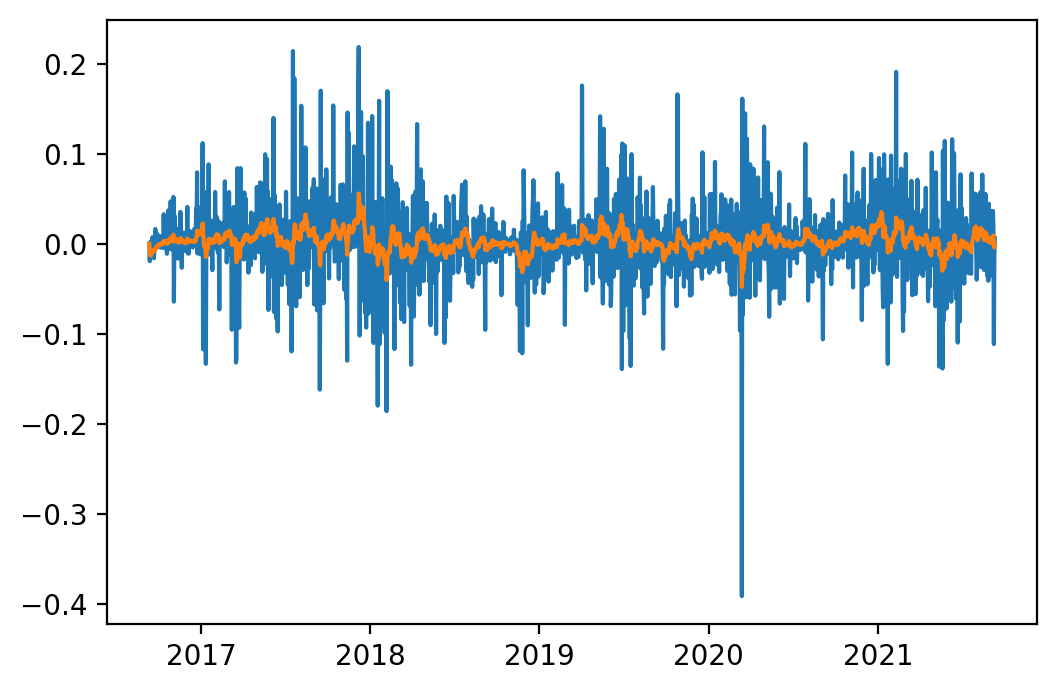

In [ ]:
BCdf['Avg_ret']=EW_avg(BCdf['Return'])
plt.figure(dpi=200)
plt.plot(BCdf['Date'],BCdf['Return'],label='Return')
plt.plot(BCdf['Date'],BCdf['Avg_ret'],label='EW_avg')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


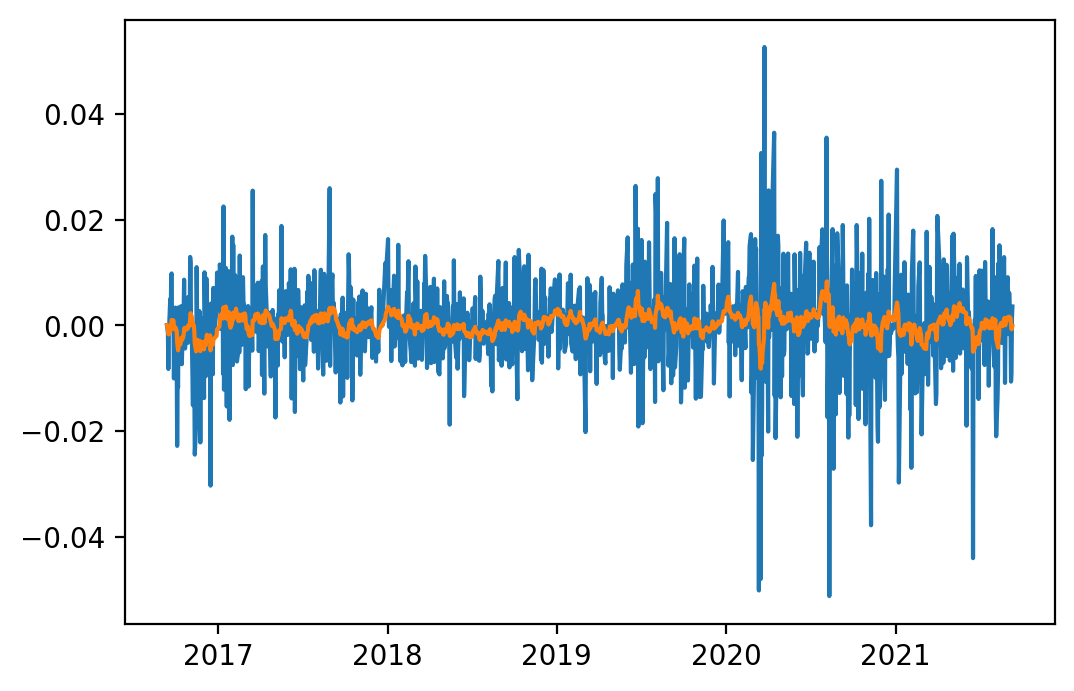

In [ ]:
Gdf['Avg_ret']=EW_avg(Gdf['Return'])
plt.figure(dpi=200)
plt.plot(Gdf['Date'],Gdf['Return'],label='Return')
plt.plot(Gdf['Date'],Gdf['Avg_ret'],label='EW_avg')
plt.show()

#合理性解释

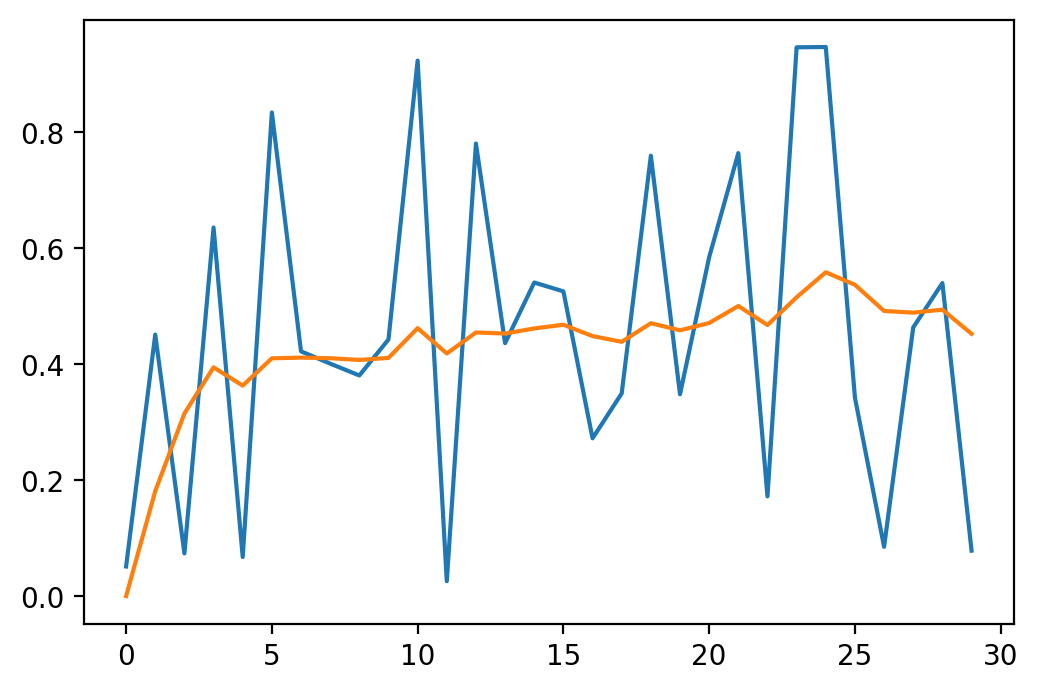

In [ ]:
y=np.random.rand(30)
plt.figure(dpi=200)
plt.plot(range(30),y,label='Return')
plt.plot(range(30),EW_avg(y),label='EW_avg')
plt.show()

#Torch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torch.utils.data as data
from sklearn.preprocessing import MinMaxScaler

#LSTM

In [ ]:
#ML Parameters
lr = 1E-4
epochs = 100
batch_size = 20

scaler = MinMaxScaler()

device = 'cuda' if torch.cuda.is_available() else 'cpu'


**构建数据集**

In [ ]:
class StockDataset(data.Dataset):
  def __init__(self,input):
    self.df=input
    self.orig_dataset = self.df[['Value','Return']].to_numpy()
    self.TLabel=self.df[['Label']].to_numpy()
    self.normalized_dataset = np.copy(self.orig_dataset)
    #self.normalized_dataset = self.normalized_dataset.reshape(-1, 1)

    self.normalized_dataset = scaler.fit_transform(self.normalized_dataset)
    #self.normalized_dataset = self.normalized_dataset.reshape(-1)

    self.sample_len = 20

  def __len__(self):
        
    if len(self.orig_dataset) > self.sample_len:
      return len(self.orig_dataset) - self.sample_len
    else:
      return 0
  
  def __getitem__(self, idx):
      target = self.normalized_dataset[idx+self.sample_len,0]
       
      i = self.normalized_dataset[idx:(idx+self.sample_len),0]

      #i = i.reshape((-1, 1))
 
      i = torch.from_numpy(i)
      i=i.reshape((-1,1))
      target = torch.Tensor([target])
      i=i.double()
      target=target.double()  
      return i, target

In [ ]:
# Load dataset
dataset = StockDataset(BCdf[['Value','Return','Label']])

# Split training and validation set
train_len = int(0.7*len(dataset))
valid_len = len(dataset) - train_len
TrainData, ValidationData = random_split(dataset,[train_len, valid_len])

# Load into Iterator (each time get one batch)
train_loader = data.DataLoader(TrainData, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = data.DataLoader(ValidationData, batch_size=batch_size, shuffle=True, num_workers=2)

# Print statistics
print("Total: ", len(dataset))
print("Training Set: ", len(TrainData))
print("Validation Set: ", len(ValidationData))

Total:  1806
Training Set:  1264
Validation Set:  542


In [ ]:
dataset.normalized_dataset

array([[4.37894574e-04, 6.41569447e-01],
       [2.47616119e-04, 6.09980961e-01],
       [2.67469881e-04, 6.44930173e-01],
       ...,
       [7.34034716e-01, 4.58969466e-01],
       [7.22427572e-01, 6.15978899e-01],
       [7.27038568e-01, 6.51896651e-01]])

In [ ]:
for i,j in train_loader:
  #print(i,j)
  continue

In [ ]:
class TempLSTM(nn.Module):

  def __init__(self):

    # Required in PyTorch Model
    super(TempLSTM, self).__init__()
        
    # Parameters
    self.feature_dim = 1
    self.hidden_dim = 500

    self.num_layers = 3
    self.output_dim = 1

    # Neural Networks
    self.lstm = nn.LSTM(self.feature_dim, self.hidden_dim, self.num_layers, dropout=0.1, batch_first=True)
    if torch.cuda.is_available():
      self.lstm.cuda()
    self.fc = nn.Linear(self.hidden_dim , self.output_dim)
  def forward(self, i):
        
    
    h0 = torch.randn([self.num_layers, i.shape[0], self.hidden_dim], dtype=torch.double, device=device) #.requires_grad_()
    c0 = torch.randn([self.num_layers, i.shape[0], self.hidden_dim], dtype=torch.double, device=device) #.requires_grad_()
        
    # Forward propagate LSTM
    out, _ = self.lstm.forward(i, (h0.detach(), c0.detach()))  # output shape (batch, sequence, hidden_dim)
    Lout = self.fc(out[:, -1, :])
    return Lout

In [ ]:
# Define model
model = TempLSTM()
model = model.double()

#model = Model(1)
print(model)

# Load into GPU if necessary

if torch.cuda.is_available():
  model = model.cuda()

# Define loss function
criterion = nn.MSELoss()

# Define optimization strategy
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

TempLSTM(
  (lstm): LSTM(1, 500, num_layers=3, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=500, out_features=1, bias=True)
)


In [ ]:
def train(model, iterator, optimizer, criterion, device):
    
  model.train()     # Enter Train Mode
  train_loss =0

  for _, (ii, targets) in enumerate(iterator):
       
    # move to GPU if necessary
    if torch.cuda.is_available():
      ii, targets = ii.cuda(), targets.cuda()
        
    # generate prediction
    #print(ii)
    output = model(ii)
    

    #print(output)    
    # calculate loss
    loss = criterion(output, targets)

    # compute gradients and update weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    # record training losses
    train_loss+=loss.item()

    # print completed result
  #print('train_loss: %f' % (train_loss))
  return train_loss

In [ ]:
def test(model, iterator, criterion, device):

  model.eval()     # Enter Evaluation Mode
  test_loss =0
  
  with torch.no_grad():
    for _, (ii, targets) in enumerate(iterator):

      # move to GPU if necessary
      ii, targets = ii.to(device), targets.to(device)
            
      # generate prediction

      output = model(ii)

      #print(output)
      
        
      # calculate loss
      loss = criterion(output,targets)
            
      # record training losses
      test_loss+=loss.item()
    
    # print completed result
  #print('test_loss: %s' % (test_loss))
  return test_loss

In [ ]:
def predict(model,data):
  if torch.cuda.is_available():
      data=data.cuda() 
  model.eval()     # Enter Evaluation Mode
  with torch.no_grad():
    pred = model(data)
    return pred

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release
from d2l import torch as d2l
from IPython import display
% matplotlib inline

In [ ]:
class Animator:
  def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
            ylim=None, xscale='linear', yscale='linear',
            fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
            figsize=(3.5, 2.5)):
    if legend is None:
      legend=[]
    d2l.use_svg_display()
    self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
    if nrows * ncols == 1:
      self.axes = [self.axes, ]
    self.config_axes = lambda: d2l.set_axes(
      self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    self.X, self.Y, self.fmts = None, None, fmts
  
  def add(self, x, y):
    # 向图表中添加多个数据点
    if not hasattr(y, "__len__"):
      y = [y]
    n = len(y)
    if not hasattr(x, "__len__"):
      x = [x] * n
    if not self.X:
      self.X = [[] for _ in range(n)]
    if not self.Y:
      self.Y = [[] for _ in range(n)]
    for i, (a, b) in enumerate(zip(x, y)):
      if a is not None and b is not None:
        self.X[i].append(a)
        self.Y[i].append(b)
    self.axes[0].cla()
    for x, y, fmt in zip(self.X, self.Y, self.fmts):
      self.axes[0].plot(x, y, fmt)
    self.config_axes()
    display.display(self.fig)
    display.clear_output(wait=True)

In [ ]:
if torch.cuda.is_available():
   model=model.cuda()

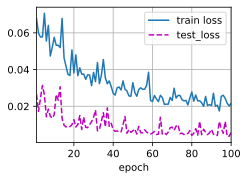

In [ ]:
#animator
animator=Animator(xlabel='epoch', xlim=[1, epochs], 
            legend=['train loss','test_loss'])


for epoch in range(epochs):
  

  
  train_loss=train(model, train_loader, optimizer, criterion, device)
  test_loss=test(model, test_loader, criterion, device)
  animator.add(epoch+1,(train_loss,test_loss))
  

In [ ]:
for _, (ii, targets) in enumerate(test_loader):
  pred=predict(model,device,ii)
  print(pred,targets)

In [ ]:
#torch.save(model,'/content/drive/MyDrive/Models/LSMT.pt')

In [ ]:
model=torch.load('/content/drive/MyDrive/Models/LSMT.pt',map_location='cpu')

#交易模拟

**股价预测**

In [ ]:
Gdf.count()

index       1255
Date        1255
USD (PM)    1255
Return      1255
Label       1255
Avg_ret     1255
dtype: int64

In [ ]:
scaler.inverse_transform([[predict(model,torch.Tensor([scaler.fit_transform(BCdf[['Value']])[0:20]]).double()).item()]])[0][0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  """Entry point for launching an IPython kernel.


565.3579685220956

In [ ]:
pred=[]
for i in range(len(BCdf)-20):
  pred.append(scaler.inverse_transform([[predict(model,torch.Tensor([scaler.fit_transform(BCdf[['Value']])[i:i+20]]).double()).item()]])[0][0])

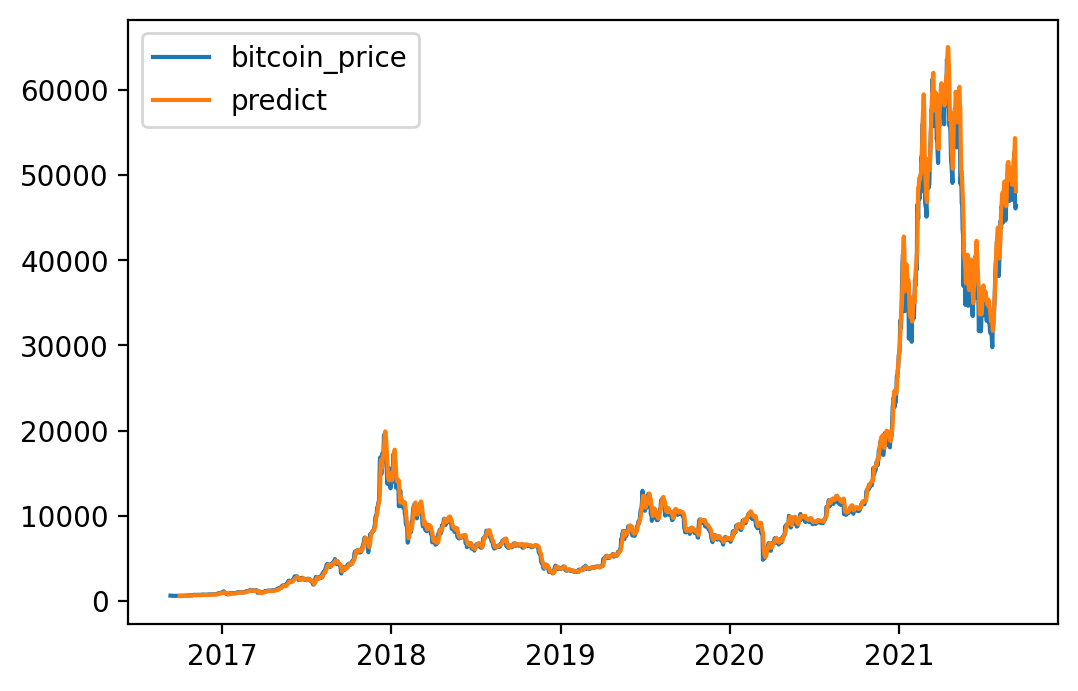

In [ ]:
plt.figure(dpi=200)
plt.plot(BCdf['Date'],BCdf['Value'],label='bitcoin_price')
plt.plot(BCdf['Date'][20:],pred,label='predict')
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
BCdf['Pred']=0
BCdf['Pred'][20:]=pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
Gscaler=MinMaxScaler()
Gscaler.fit_transform(Gdf[['USD (PM)']])
Gpred=[]
for i in range(len(Gdf)-20):
  Gpred.append(Gscaler.inverse_transform([[predict(model,torch.Tensor([Gscaler.fit_transform(Gdf[['USD (PM)']])[i:i+20]]).double()).item()]])[0][0])

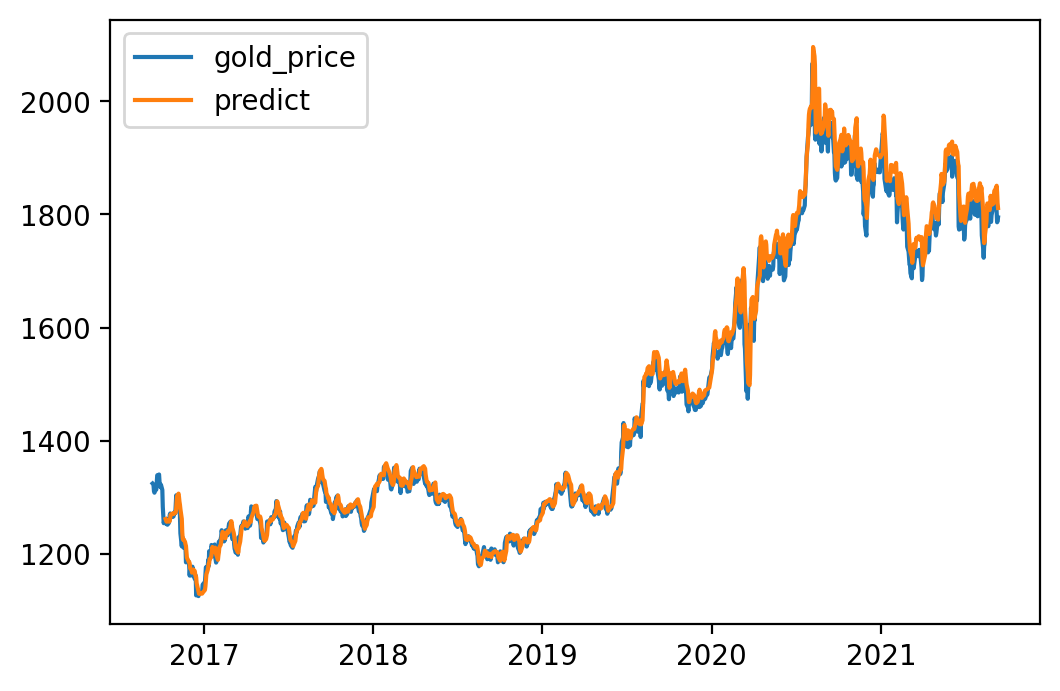

In [ ]:
plt.figure(dpi=200)
plt.plot(Gdf['Date'],Gdf['USD (PM)'],label='gold_price')
plt.plot(Gdf['Date'][20:],Gpred,label='predict')
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
Gdf['Pred']=0
Gdf['Pred'][20:]=Gpred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
Pred_ret=[]
for i in range(20,len(BCdf)):
  Pred_ret.append((BCdf['Pred'][i]-BCdf['Value'][i])/BCdf['Value'][i])

BCdf['pred_ret']=0
BCdf['pred_ret'][20:]=Pred_ret

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
Pred_ret=[]
for i in range(20,len(Gdf)):
  Pred_ret.append((Gdf['Pred'][i]-Gdf['USD (PM)'][i])/Gdf['USD (PM)'][i])

Gdf['pred_ret']=0
Gdf['pred_ret'][20:]=Pred_ret

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


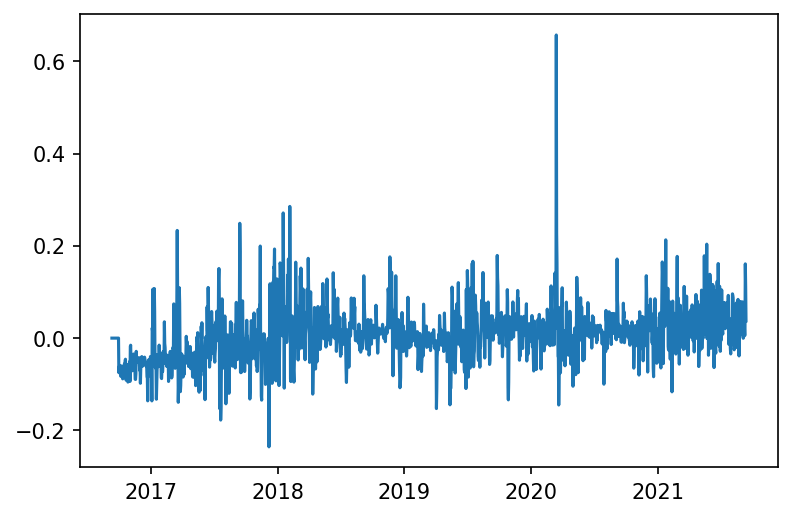

In [ ]:
plt.figure(dpi=150)
plt.plot(BCdf['Date'],BCdf['pred_ret'])

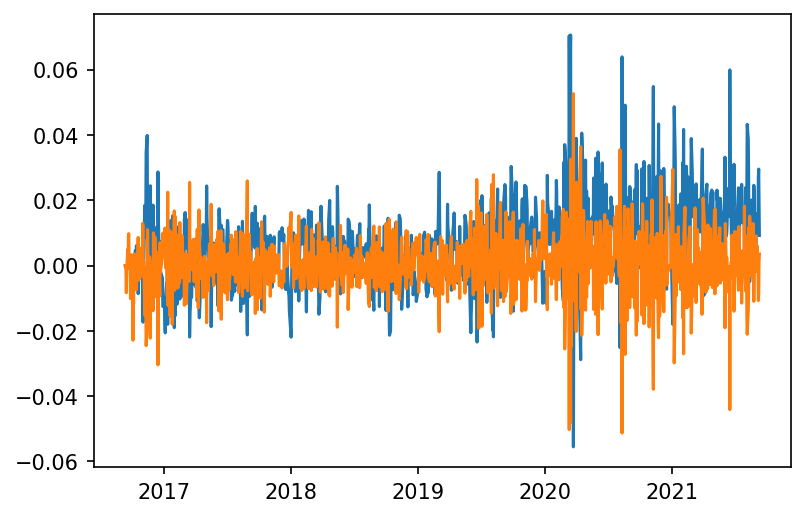

In [ ]:
plt.figure(dpi=150)
plt.plot(Gdf['Date'],Gdf['pred_ret'])
plt.plot(Gdf['Date'],Gdf['Return'])

**计算均方差和协方差**

In [ ]:
xy=[]

In [ ]:
j=0
for i in range(len(BCdf)):
  xy.append(BCdf['Return'][i]*Gdf['Return'][j])
  if BCdf['Date'][i]>=Gdf['Date'][j]:
    j=j+1

In [ ]:
BCdf['xy']=xy

In [ ]:
BCdf['xy_avg']=EW_avg(BCdf['xy'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


In [ ]:
cov=[]
j=0
for i in range(len(BCdf)):
  cov.append(BCdf['xy_avg'][i]-BCdf['Avg_ret'][i]*Gdf['Avg_ret'][j])
  if BCdf['Date'][i]>=Gdf['Date'][j]:
    j=j+1

In [ ]:
BCdf['cov']=cov

In [ ]:
def squareX_EX(df):
  return (df['Return']-df['Avg_ret'])**2

Exponentially weighted averages

$X_t=\beta X_{t-1}+(1-\beta)R_t$  

$V_t=\beta V_{t-1}+(1-\beta)(R_t-X_t)^2$

where:
*  X_t|第t天的指数加权平均收益率
*  R_t|第t天的实际收益率
*  V_t|第t天的偏差值

In [ ]:
BCdf['squareX_EX']=squareX_EX(BCdf)
BCdf['EW_var']=EW_avg(BCdf['squareX_EX'])

Gdf['squareX_EX']=squareX_EX(Gdf)
Gdf['EW_var']=EW_avg(Gdf['squareX_EX'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


In [ ]:
BCdf

,Date,Value,Return,Label,Avg_ret,Pred,pred_ret,xy,xy_avg,cov,squareX_EX,EW_var
0,2016-09-11,621.65,0.000000,2,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
1,2016-09-12,609.67,-0.019271,3,-0.007738,0.000000,0.000000,-0.000000,0.000000e+00,0.000000,0.000133,0.000053
2,2016-09-13,610.92,0.002050,1,-0.012496,0.000000,0.000000,-0.000001,-2.718485e-07,-0.000004,0.000212,0.000128
3,2016-09-14,608.82,-0.003437,2,-0.013178,0.000000,0.000000,0.000005,2.828321e-07,-0.000010,0.000095,0.000142
4,2016-09-15,610.38,0.002562,1,-0.011641,0.000000,0.000000,-0.000021,-1.874159e-06,-0.000022,0.000202,0.000148
...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2021-09-06,51769.06,0.036472,0,0.008273,52028.944334,0.005020,-0.000042,-2.549044e-06,-0.000014,0.000795,0.000622
1822,2021-09-07,52677.40,0.017546,1,0.009201,53052.653751,0.007124,-0.000187,-2.102875e-05,-0.000022,0.000070,0.000567
1823,2021-09-08,46809.17,-0.111399,3,-0.002859,54336.764270,0.160815,0.000998,8.090488e-05,0.000079,0.011781,0.001688
1824,2021-09-09,46078.38,-0.015612,3,-0.004135,51217.036502,0.111520,-0.000020,7.084758e-05,0.000069,0.000132,0.001533


In [ ]:
#args
epochs=len(BCdf)

**组合投资策略**

$R_t=\frac{T_t}{T_{t-1}}-1$

In [ ]:
def portfolio(i,j,W,beta=0.3,BCFrate=0.02,GFrate=0.01):
  pR=[]
  pV=[]
  w_0=np.array(W[1:])*100
  mR,mV,alc=-100,-100,W[1]

  '''
  投资方案为20%—80%
  变化幅度为5%
  '''
  for w in range(20,80,1):
    c=abs(w-w_0[0])*BCFrate+(1-w-w_0[1])*GFrate
    portfolioR=w*BCdf['Avg_ret'][i]+(100-w)*Gdf['Avg_ret'][j]-c
    portfolioV=w*BCdf['EW_var'][i]+(100-w)*Gdf['EW_var'][j]+w*(100-w)*BCdf['cov'][i]
    if portfolioV < beta:
      if mR<portfolioR:
        mR=portfolioR
        mV=portfolioV
        alc=w/100
    pR.append(portfolioR)
    pV.append(portfolioV)
  if mR < 0:
    alc=0
  return pR,pV,[mR,mV,alc]

$\mu=E(R)=\sum w_i(X_i-S_i)$  

$\sigma^2=Var(R)=\sum\sum w_iw_jcov(X_i,X_j)$

where:
*  $\mu|组合收益率$
*  $\sigma^2|组合风险率$
*  $w_i|第i项的投资额$
*  $X_i|第i项的收益率$
*  $S_i|第i项的交易费率$

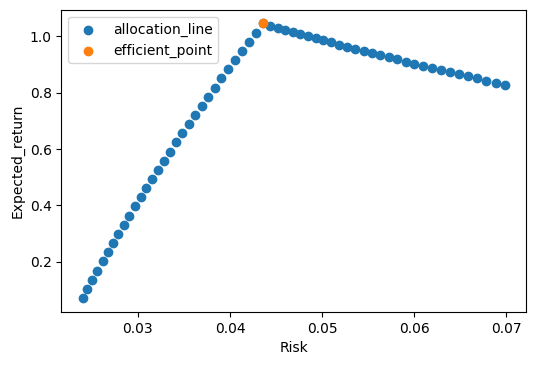

In [ ]:
pR,pV,eP=portfolio(900,1000,[0,0.5,0.5])
plt.figure(dpi=100)
plt.scatter(pV,pR,label='allocation_line')
plt.scatter(eP[1],eP[0],label='efficient_point')
plt.xlabel('Risk')
plt.ylabel('Expected_return')
plt.legend()


In [ ]:
eP

[1.37784909006433, 0.16567712180163763, 0.5]

In [ ]:
BCdf.describe()

,Value,Return,Label,Avg_ret,Pred,pred_ret,xy,xy_avg,cov,squareX_EX,EW_var
count,1826.000000,1826.000000,1826.00000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000
mean,12206.068281,0.003233,1.50000,0.003176,12476.818215,0.006525,0.000014,0.000013,0.000011,0.001458,0.001451
std,14043.891627,0.041476,1.11883,0.010064,14543.597061,0.057246,0.000414,0.000078,0.000078,0.004397,0.001460
min,594.080000,-0.391404,0.00000,-0.047777,0.000000,-0.235553,-0.007748,-0.000564,-0.000774,0.000000,0.000000
25%,3994.982500,-0.012508,0.25000,-0.002293,3999.749005,-0.026106,-0.000051,-0.000018,-0.000019,0.000040,0.000554
50%,7924.460000,0.001439,1.50000,0.002536,7999.015549,0.005833,0.000002,0.000009,0.000007,0.000238,0.001011
75%,11084.730000,0.019062,2.75000,0.008945,11331.701711,0.033907,0.000062,0.000046,0.000043,0.001102,0.001853
max,63554.440000,0.218669,3.00000,0.055862,65031.129632,0.656799,0.006148,0.000511,0.000394,0.118080,0.014957


In [ ]:
def simulate(epoch,tradeGap,beta=0.3,BCFrate=0.02,GFrate=0.01):
  j=0
  state=[[1000,0,0]]
  transactionFee=[]
  W=[]
  w=[1,0,0]
  for i in range(1,epoch):
    #print(Gdf['Date'][j],BCdf['Date'][i])
    #计算总资产
  
    total=state[i-1][0]+state[i-1][1]*(1+BCdf['Return'][i])+state[i-1][2]*(1+Gdf['Return'][j])


    #分配策略
    if i>20 and i%tradeGap==0:
      pR,pV,eP=portfolio(i,j,w,beta)  #配比(和为1)
      if eP[2]!=0:
        w=[0,eP[2],1-eP[2]]
      else:
        w=[1,0,0]

    cash=w[0]*total
    bc=w[1]*total
    gold=w[2]*total
  
  
    #交易费
    bcFee=abs(bc-state[i-1][1])*BCFrate
    goldFee=abs(gold-state[i-1][2])*GFrate
    transactionFee.append(bcFee+goldFee)

    #结余资产
    total=total-bcFee-goldFee
    bc=total*w[1]
    gold=w[2]*total
    cash=total-bc-gold
    state.append([cash,bc,gold])

    W.append(w)
  
    #保持日期同步
    if BCdf['Date'][i]>=Gdf['Date'][j]:
      j=j+1
    
  return transactionFee,W,state

In [ ]:
transactionFee,W,state=simulate(epochs,29,0.49,0.04,0.02)


200%|5749.531074105381
100%|4271.741445766016  
50%|2619.119064059438

|  |transactionCost|Value|
|---|---|---|
|200%|5749.53|11648.55|
|100%|4271.74|20320.91|
|50%|2619.12|26812.17|
|10%|618.24|33452.79|


In [ ]:
sum(transactionFee)

5749.531074105381

In [ ]:
state=np.array(state)
len(state)
asset=pd.DataFrame()
asset['Date']=BCdf['Date']
asset['Property']=state.sum(axis=1)
profit=[0]
for i in range(len(asset)-1):
  profit.append((asset['Property'][i+1]-asset['Property'][i])/asset['Property'][i])
asset['profit_rate']=profit

In [ ]:
asset=asset.set_index('Date')

In [ ]:
def maximum_drawdown(asset):
  return (asset['Property'][asset['Property'].idxmax()]-asset['Property'][asset['Property'][asset['Property'].idxmax():].idxmin()])/asset['Property'][asset['Property'].idxmax()]

In [ ]:
def std(asset):
  return asset['profit_rate'].std()

In [ ]:
#def sharp(asset):
#  (asset['Property'][len(asset)-1]-asset['Property'][0])/asset['Property'][0]/asset['Property']

In [ ]:
df2017=pd.DataFrame(asset[['Property','profit_rate']]['2017'])
df2018=pd.DataFrame(asset[['Property','profit_rate']]['2018'])
df2019=pd.DataFrame(asset[['Property','profit_rate']]['2019'])
df2020=pd.DataFrame(asset[['Property','profit_rate']]['2020'])
df2021=pd.DataFrame(asset[['Property','profit_rate']]['2021'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-pack

In [ ]:
df2017

,Property,profit_rate
Date,,
2017-01-01,1000.000000,0.000000
2017-01-02,1000.000000,0.000000
2017-01-03,1000.000000,0.000000
2017-01-04,1000.000000,0.000000
2017-01-05,976.000000,-0.024000
...,...,...
2017-12-27,4739.158675,0.100189
2017-12-28,4465.038084,-0.057842
2017-12-29,4443.729087,-0.004772


In [ ]:
x=[]
x.append(maximum_drawdown(df2017))
x.append(maximum_drawdown(df2018))
x.append(maximum_drawdown(df2019))
x.append(maximum_drawdown(df2020))
x.append(maximum_drawdown(df2021))

In [ ]:
x

[0.23872458998938598,
 0.5070849356362506,
 0.29646097066852156,
 0.0,
 0.3333079135924638]

|Date|maximum_drawdown|
|---|---|
|2017|23.9%|
|2018|50.7%|
|2019|29.6%|
|2020|0%|
|2021|33.3%


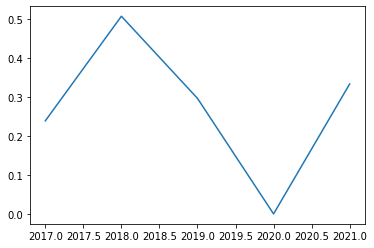

In [ ]:
plt.plot(range(2017,2022,1),x)

In [ ]:
year_std=[]
year_std.append(std(df2017))
year_std.append(std(df2018))
year_std.append(std(df2019))
year_std.append(std(df2020))
year_std.append(std(df2021))
year_std

[0.034613001437656575,
 0.014727648478509606,
 0.019511950496331632,
 0.022913892271334304,
 0.02756512603220824]

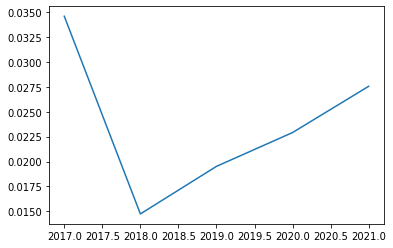

In [ ]:
plt.plot(range(2017,2022,1),year_std)

|Date|std|
|---|---|
|2017|3.46%|
|2018|1.47%|
|2019|1.95%|
|2020|2.29%|
|2021|2.76%


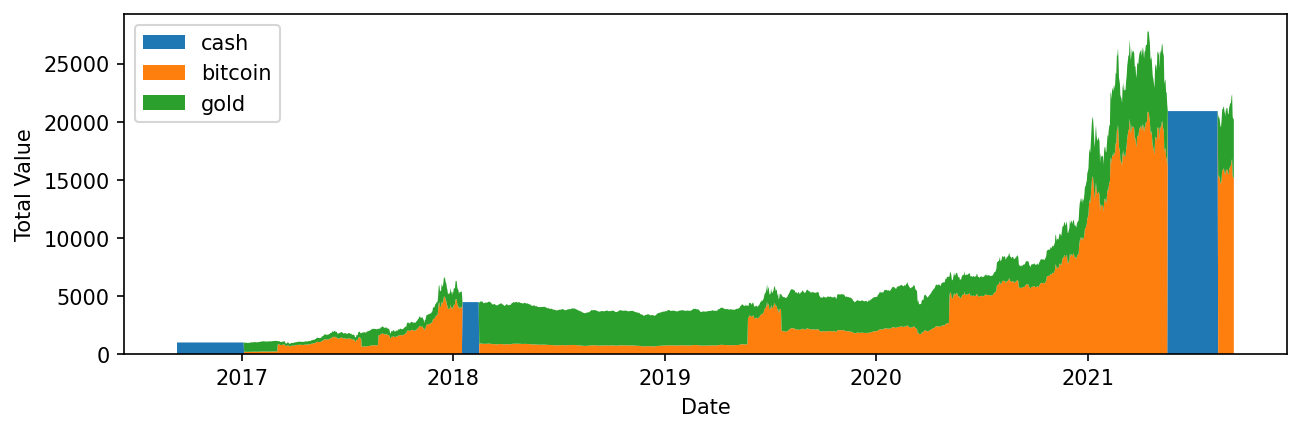

In [ ]:
colors = ['#ff9999','#9999ff','#cc1234']
plt.figure(dpi=150,figsize=(10, 3))
plt.stackplot(BCdf['Date'], 
       state[:,0],state[:,1],state[:,2], # 可变参数，接受多个y
       labels = ['cash','bitcoin','gold'], # 定义各区块面积的含义
       #colors = colors # 设置各区块的填充色
       )

ax=plt.gca()
#ax.xaxis.set_major_locator(MultipleLocator(90))
#ax.xaxis.set_tick_params(rotation=90)
plt.xlabel('Date')
plt.ylabel('Total Value')
plt.legend(loc = 'upper left')

$\frac{收益}{本金}^{-\frac{持有天数}{365}}$

In [ ]:
res=pd.DataFrame()
res['Date']=BCdf['Date']
res['Property']=state.sum(axis=1)

In [ ]:
profit=[0]
for i in range(len(res)-1):
  profit.append((res['Property'][i+1]-res['Property'][i])/res['Property'][i])
res['profit_rate']=profit

In [ ]:
res['profit_rate'].std()

0.02385577020805624

In [ ]:
res['Date'][1000]-res['Date'][1]

Timedelta('999 days 00:00:00')

In [ ]:
pred_acc=[]
for i in range(20,len(Gdf)-1):
  pred_acc.append(Gdf['pred_ret'][i]*Gdf['Return'][i+1])

In [ ]:
pred_acc=np.array(pred_acc)
len(pred_acc[pred_acc>=0])/len(pred_acc)

0.4991896272285251

In [ ]:
def test(epochs,gap,beta,BCFrate=0.02,GFrate=0.01):
  transactionFee,W,state=simulate(epochs,gap,beta,BCFrate,GFrate)
  state=np.array(state)
  asset=pd.DataFrame()
  asset['Date']=BCdf['Date']
  asset['Property']=state.sum(axis=1)
  profit=[0]
  for i in range(len(asset)-1):
    profit.append((asset['Property'][i+1]-asset['Property'][i])/asset['Property'][i])
  asset['profit_rate']=profit
  return asset['profit_rate'].std(),sum(transactionFee),state.sum(axis=1)[len(state)-1],(asset['Property'][asset['Property'].idxmax()]-asset['Property'][asset['Property'][asset['Property'].idxmax():].idxmin()])/asset['Property'][asset['Property'].idxmax()]

In [ ]:
cycle_test_inf=[]
for i in range(1,35,2):
  profit_rate_std,transactionFee,property_sum,maximum_drawdown=test(len(BCdf),i,0.49)
  cycle_test_inf.append([i,profit_rate_std,transactionFee,property_sum,maximum_drawdown])

In [ ]:
cycle_test_inf=np.array(cycle_test_inf)

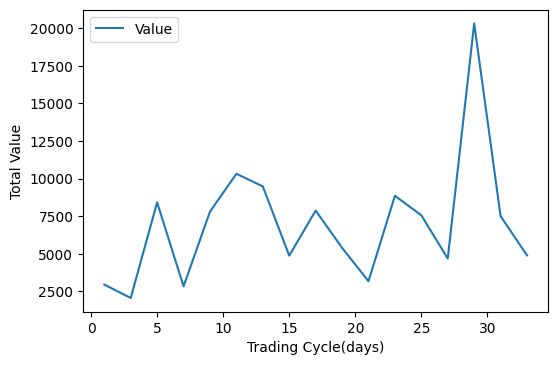

In [ ]:

#plt.plot(range(1,35,2),test_inf[:,3],label='Value')
fig = plt.figure(dpi=100)
ax1 = fig.add_subplot()
ax1.plot(range(1,35,2),cycle_test_inf[:,3],label='Value')
ax1.set_xlabel('Trading Cycle(days)')
ax1.set_ylabel('Total Value')
ax1.legend()
#ax2 = ax1.twinx()
#ax2.plot(range(1,35,2),cycle_test_inf[:,4],label='Maximum Drawdowm',c='r')
#x2.set_ylabel('Maximum Drawdowm')
#fig.legend(loc='upper left')
#ax2.legend(loc='upper left')

In [ ]:
test_inf=[]
for i in range(1,100,1):
  profit_rate_std,transactionFee,property_sum,maximum_drawdown=test(len(BCdf),29,i/100)
  test_inf.append([i,profit_rate_std,transactionFee,property_sum,maximum_drawdown])
test_inf=np.array(test_inf)

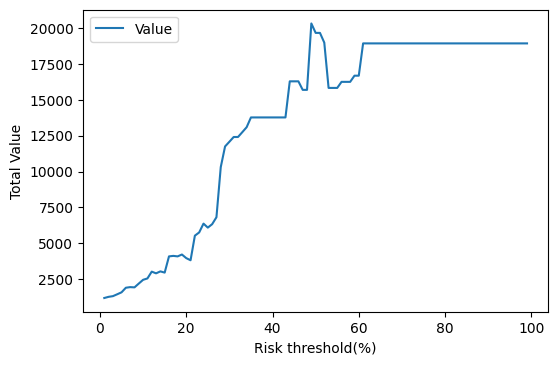

In [ ]:
plt.figure(dpi=100)
plt.plot(range(1,100,1),test_inf[:,3],label='Value')
plt.xlabel('Risk threshold(%)')
plt.ylabel('Total Value')
plt.legend(loc = 'upper left')

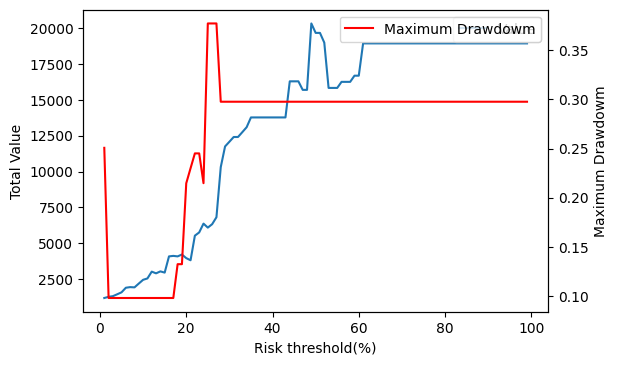

In [ ]:
fig = plt.figure(dpi=100)
ax1 = fig.add_subplot()
ax1.plot(range(1,100,1),test_inf[:,3],label='Value')
ax1.set_xlabel('Risk threshold(%)')
ax1.set_ylabel('Total Value')

ax2 = ax1.twinx()
ax2.plot(range(1,100,1),test_inf[:,4],label='Maximum Drawdowm',c='r')
ax2.set_ylabel('Maximum Drawdowm')
ax1.legend()
ax2.legend()

In [ ]:
profit_rate_std,transactionFee,property_sum,maximum_drawdown=test(len(BCdf),29,0.49)

In [ ]:
property_sum

20320.913471216907

$w_t=第t天的投资配置比例|∈\mathbb{R}^{3X1}$   
$T_t=第t天的价格$  
$R_t=第t天的收益率$   
$\mu =投资组合收益$    
$σ^2 =投资组合的风险$

  在传统的组合投资策略中,一般使用平均收益和均方差来分布衡量一支股票的收益和风险.在本题中,我们通过投资组合来对每一个周期的的投资进行决策,而平均收益和均方差并不能有效的判断该股票在一段时期内的情况,所以,我们选择使用指数加权法进行计算

    公式

  其中$\beta$表示权重下降的速率,该公式计算结果类似于最近的$\frac{1}{1-\beta}组数据的均值和均方差$